In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import uniform_shell_sampler, make_nice_plots
from scipy import stats
from tqdm import tqdm
from scipy.special import erf
from concurrent.futures import as_completed, ThreadPoolExecutor
from multiprocessing import cpu_count

make_nice_plots()



In [2]:
def dVdr_prior(r, rmax):
    '''Uniform in volume distribution on radius, normalized between 0 and rmax.'''
    return np.where((r < rmax) & (r > 0), r**2 / rmax**3 * 3, 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:36<00:00, 10.35it/s]


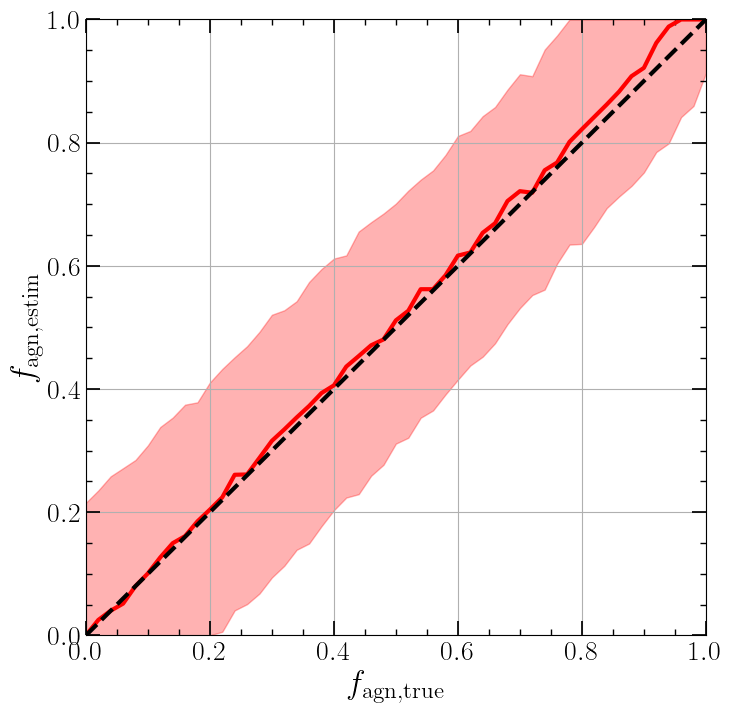

In [7]:
####################################################################
USE_GW_SELECTION_EFFECTS = False
GW_DIST_ERR = 1  # Absolute error
RMIN = 0
RMAX_GW = 100
RTHRESH_GW = 100
NAGN = int(1e2)
N_MC_SAMPS = int(1e4)
rr = np.linspace(RMIN, RMAX_GW, 1000)
CHUNK = int(100)
NGW_ALT = CHUNK
NGW_AGN = CHUNK
NCPU = cpu_count()
####################################################################


use_N_gws = CHUNK
n_trials = 1000
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn
p_det = 1


def chunked_llh_processing(total_cw_prob_agn, total_cw_prob_alt, total_prob_alt, fagn_times_fobsc):
    log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
    for i in range(int(use_N_gws / gw_chunk_size)):
        gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
        cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
        cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
        alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

        for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
            llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
            fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
            fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
            fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
            alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

            log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
            log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    return log_llh_numerator


def chunked_gw_processing(obs_pos_gw, agn_pos):
    p_agn = np.zeros(len(obs_pos_gw))
    p_alt = np.zeros(len(obs_pos_gw))
    for i in range(int(len(obs_pos_gw) / CHUNK) + 1):  # Chunking to keep #mc samps x #gws <= 1e6 for memory usage
        start, stop = int(i * CHUNK), min(int((i + 1) * CHUNK), len(obs_pos_gw))

        posterior = lambda x: stats.norm.pdf(x, loc=obs_pos_gw[start:stop], scale=GW_DIST_ERR)
        p_agn[start:stop] = np.sum( posterior(agn_pos[:,np.newaxis]), axis=0 ) / len(agn_pos)
        # print(posterior(agn_pos[:,np.newaxis]).shape)
        # plt.figure()
        # xx = np.linspace(RMIN, RMAX_GW, 100)
        # plt.plot(xx, posterior(xx[:,np.newaxis])[:,0])
        # plt.plot(xx, posterior(xx[:,np.newaxis])[:,1])
        # plt.plot(xx, posterior(xx[:,np.newaxis])[:,2])
        # plt.hist(agn_pos, density=True, bins=30, zorder=-1)
        # plt.show()
        # break

        mc_samps = np.random.normal(loc=obs_pos_gw[start:stop], scale=GW_DIST_ERR, size=(N_MC_SAMPS, int(stop - start)))
        p_alt[start:stop] = np.sum( dVdr_prior(mc_samps, RMAX_GW), axis=0) / N_MC_SAMPS  # NORMALIZE UP TO RMAX_GW, since p_rate(r > RMAX_GW) = 0
    return p_agn, p_alt


## These two lines are for making the underlying truth equal to the actual realization of that truth
use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
true_fagns = use_N_agn_events / use_N_gws
use_N_alt_events = use_N_gws - use_N_agn_events
realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth


def full_analysis():
    agn_pos, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NAGN)  # NO AGN NEEDED ABOVE RMAX_GW, p_rate = 0
    # print(agn_pos)

    # GWs & likelihood
    # GENERATE GWS UP TO RMAX_GW
    true_pos_gw_alt, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NGW_ALT)
    true_pos_gw_agn = np.random.choice(agn_pos, NGW_AGN)

    # MEASURE
    obs_pos_gw_alt = np.random.normal(loc=true_pos_gw_alt, scale=GW_DIST_ERR)
    obs_pos_gw_agn = np.random.normal(loc=true_pos_gw_agn, scale=GW_DIST_ERR)

    p_agn_agn_gws, p_alt_agn_gws = chunked_gw_processing(obs_pos_gw_agn, agn_pos)
    p_agn_alt_gws, p_alt_alt_gws = chunked_gw_processing(obs_pos_gw_alt, agn_pos)

    return p_agn_agn_gws, p_alt_agn_gws, p_agn_alt_gws, p_alt_alt_gws


def full_analysis_likelihood_thread(index):
    p_agn_agn_gws, p_alt_agn_gws, p_agn_alt_gws, p_alt_alt_gws = full_analysis()

    ### Some translations to reuse my code ###
    cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
    cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
    palt = cw_palt  # c = 1
    agn_events = np.ones(len(cw_pagn), dtype=bool)
    agn_events[NGW_ALT:] = 0
    alt_events = ~agn_events
    ##########################################

    # pos_idx = np.arange(use_N_gws, dtype=int)
    
    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
        print('Chunking...')

    ## Use these lines for binomial realization of truth TODO: get this working properly
    # true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    # use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn
    # use_N_alt_events = use_N_gws - use_N_agn_events
    # realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    alt_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    for k in range(N_true_fagns):
        arr = np.arange(use_N_gws)
        np.random.shuffle(arr)
        agn_idx[k,:] = arr
        np.random.shuffle(arr)
        alt_idx[k,:] = arr + NGW_AGN
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory
        log_llh_numerator = chunked_llh_processing(total_cw_prob_agn, total_cw_prob_alt, total_prob_alt, fagn_times_fobsc)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )

    log_llh_denominator = use_N_gws * np.log(p_det)  # GW SELECTION EFFECTS
    log_llh = log_llh_numerator - log_llh_denominator
    return index, log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

estimation_arr = np.zeros((n_trials, N_true_fagns))
with ThreadPoolExecutor(max_workers=NCPU) as executor:
    future_to_index = {executor.submit(full_analysis_likelihood_thread, index): index for index in range(n_trials)}
    for future in tqdm(as_completed(future_to_index), total=n_trials):
        try:
            i, estimates = future.result(timeout=20)
            estimation_arr[i,:] = estimates
        except Exception as e:
            print(f"Error processing event {future_to_index[future]}: {e}")


fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


If I ever return to this example: do I need to select the AGN below RTHRESH for selection effects?


/var/tmp/pouw/ipykernel_1299551/1141800152.py:33: RuntimeWarning: invalid value encountered in scalar divide
  empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true


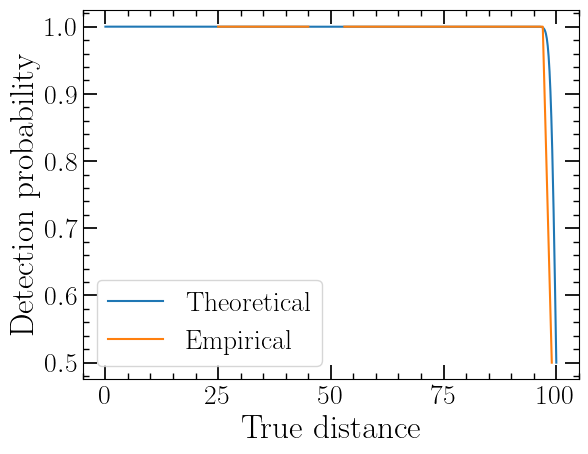

Detection probability: 1
Detected: 100 from AGN and 100 from ALT.


In [8]:
def detection_prob(r, r_thresh, r_err):
    return 0.5 * (1 + erf( (r_thresh - r) / (np.sqrt(2) * r_err)) )


# AGN catalog
print('If I ever return to this example: do I need to select the AGN below RTHRESH for selection effects?')
agn_pos, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NAGN)  # NO AGN NEEDED ABOVE RMAX_GW, p_rate = 0
# agn_pos = np.array([69.99534705])

# GWs & likelihood
# GENERATE GWS UP TO RMAX_GW
true_pos_gw_alt, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NGW_ALT)
true_pos_gw_agn = np.random.choice(agn_pos, NGW_AGN)
true_pos_all = np.append(true_pos_gw_agn, true_pos_gw_alt)

# MEASURE
obs_pos_gw_alt = np.random.normal(loc=true_pos_gw_alt, scale=GW_DIST_ERR)
obs_pos_gw_agn = np.random.normal(loc=true_pos_gw_agn, scale=GW_DIST_ERR)
obs_pos_all = np.append(obs_pos_gw_agn, obs_pos_gw_alt)


### CHECK IF DETECTION PROB IS CORRECT ###
xx = np.linspace(0, RMAX_GW, 1000)
plt.figure()
plt.plot(xx, detection_prob(xx, RTHRESH_GW, GW_DIST_ERR), label='Theoretical')
edges = np.linspace(0, RMAX_GW, 51)
empericial_detection_prob = np.zeros(len(edges) - 1)
for i in range(len(edges) - 1):
    selec = (true_pos_all > edges[i]) & (true_pos_all < edges[i + 1])
    data_in_bin = obs_pos_all[selec]
    n_gws_in_bin_true = len(data_in_bin)
    n_gws_in_bin_obs = np.sum(data_in_bin < RTHRESH_GW)
    empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true
plt.plot(edges[:-1] + np.diff(edges)[0] * 0.5, empericial_detection_prob, label='Empirical')
plt.xlabel('True distance')
plt.ylabel('Detection probability')
plt.legend()
plt.show()
###########################################


if USE_GW_SELECTION_EFFECTS:
    # ONLY KEEP EVENTS WITH OBSERVED DISTANCES BELOW THRESHOLD
    obs_pos_gw_alt = obs_pos_gw_alt[obs_pos_gw_alt < RTHRESH_GW]
    obs_pos_gw_agn = obs_pos_gw_agn[obs_pos_gw_agn < RTHRESH_GW]
    obs_pos_all = np.append(obs_pos_gw_agn, obs_pos_gw_alt)
    p_det = np.sum( detection_prob(agn_pos, RTHRESH_GW, GW_DIST_ERR) ) / len(agn_pos)
else:
    p_det = 1

print(f'Detection probability: {p_det}')
print(f'Detected: {len(obs_pos_gw_agn)} from AGN and {len(obs_pos_gw_alt)} from ALT.')


In [17]:
p_agn_agn_gws, p_alt_agn_gws = chunked_gw_processing(obs_pos_gw_agn, agn_pos)
p_agn_alt_gws, p_alt_alt_gws = chunked_gw_processing(obs_pos_gw_alt, agn_pos)

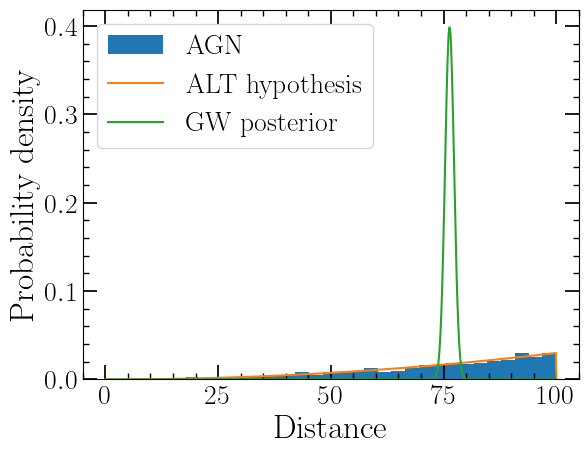

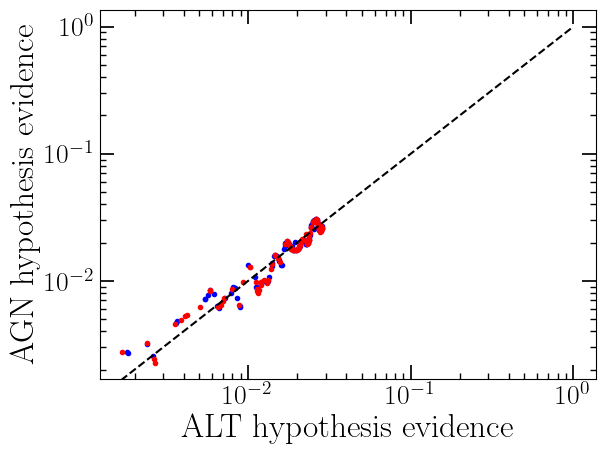

In [18]:
posterior = lambda x: stats.norm.pdf(x, loc=obs_pos_gw_alt[5], scale=GW_DIST_ERR)

plt.figure()
plt.hist(agn_pos, bins=30, density=True, label='AGN')
plt.plot(rr, dVdr_prior(rr, RMAX_GW), label='ALT hypothesis')
plt.plot(rr, posterior(rr), label='GW posterior')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Probability density')
plt.show()

plt.figure()
plt.scatter(p_alt_agn_gws, p_agn_agn_gws, color='blue', marker='.')
plt.scatter(p_alt_alt_gws, p_agn_alt_gws, color='red', marker='.')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='black', linestyle='dashed')
plt.loglog()
plt.xlabel('ALT hypothesis evidence')
plt.ylabel('AGN hypothesis evidence')
plt.show()


In [19]:
### Some translations to reuse my code ###
cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
palt = cw_palt  # c = 1
agn_events = np.ones(int(len(obs_pos_gw_agn) + len(obs_pos_gw_alt)), dtype=bool)
agn_events[len(obs_pos_gw_agn):] = 0
alt_events = ~agn_events
##########################################

use_N_gws = CHUNK
n_trials = len(cw_pagn) // (2 * use_N_gws)

max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn

if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=False)
    alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=False)
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )

    log_llh_denominator = use_N_gws * np.log(p_det)  # GW SELECTION EFFECTS
    log_llh = log_llh_numerator - log_llh_denominator
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(agn_pos)


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

100%|██████████| 10000/10000 [23:00<00:00,  7.25it/s]


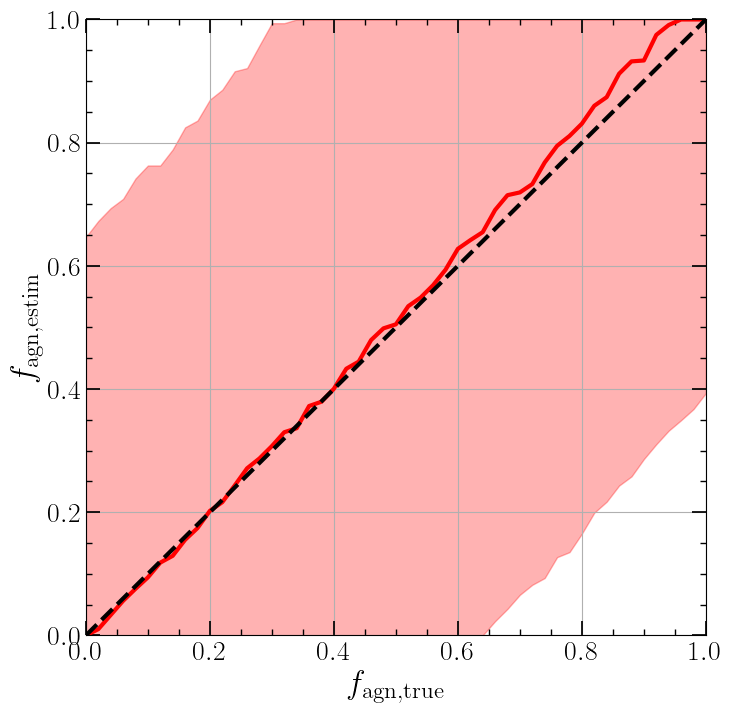

In [6]:
def full_analysis():
    agn_pos, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NAGN)  # NO AGN NEEDED ABOVE RMAX_GW, p_rate = 0

    # GWs & likelihood
    # GENERATE GWS UP TO RMAX_GW
    true_pos_gw_alt, _, _ = uniform_shell_sampler(RMIN, RMAX_GW, NGW_ALT)
    true_pos_gw_agn = np.random.choice(agn_pos, NGW_AGN)

    # MEASURE
    obs_pos_gw_alt = np.random.normal(loc=true_pos_gw_alt, scale=GW_DIST_ERR)
    obs_pos_gw_agn = np.random.normal(loc=true_pos_gw_agn, scale=GW_DIST_ERR)

    p_agn_agn_gws, p_alt_agn_gws = chunked_gw_processing(obs_pos_gw_agn, agn_pos)
    p_agn_alt_gws, p_alt_alt_gws = chunked_gw_processing(obs_pos_gw_alt, agn_pos)

    return p_agn_agn_gws, p_alt_agn_gws, p_agn_alt_gws, p_alt_alt_gws


use_N_gws = CHUNK
n_trials = 10000
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn
p_det = 1

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    p_agn_agn_gws, p_alt_agn_gws, p_agn_alt_gws, p_alt_alt_gws = full_analysis()

    ### Some translations to reuse my code ###
    cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
    cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
    palt = cw_palt  # c = 1
    agn_events = np.ones(len(cw_pagn), dtype=bool)
    agn_events[NGW_ALT:] = 0
    alt_events = ~agn_events
    ##########################################
    
    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
        print('Chunking...')

    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    # true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    # use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    alt_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    for k in range(N_true_fagns):
        possible_idx = np.arange(use_N_gws, dtype=int)
        np.random.shuffle(possible_idx)
        agn_idx[k,:] = possible_idx
        np.random.shuffle(possible_idx)
        alt_idx[k,:] = possible_idx + CHUNK
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )

    log_llh_denominator = use_N_gws * np.log(p_det)  # GW SELECTION EFFECTS
    log_llh = log_llh_numerator - log_llh_denominator
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
